<a href="https://colab.research.google.com/github/micahming/lus-preds/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pytz

from glob import glob
from datetime import datetime
import openpyxl
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import warnings
warnings.filterwarnings('ignore')


# READ DATA

In [ ]:
def wrangle(filepath):

    df =pd.read_excel(filepath)
    #Create timestamp
    file_name = f" {filepath} "
    file_name = file_name.replace(".xlsx.xls","").replace("/content/LUSE_STOCK/","").replace(" ","")
    formalt= '%Y-%m-%d'
    timestamp = datetime.strptime(file_name,formalt)


    #Adding Column Names
    column_row_1 = list(df.iloc[8])
    column_row_2=[str(item) for item in (list(df.iloc[9]))]
    column_row_3=[str(item) for item in (list(df.iloc[10]))]

    column_names=[]
    count = 0
    for name in column_row_1:
        freshname=column_row_1[count] + column_row_2[count]+ column_row_3[count]
        new = freshname.replace("nan","",2)
        column_names.append(new)
        count=count+1

    df.columns = column_names




    #Create StringCheck

    string_check = ['AELZ', 'ATEL', 'BATA', 'BATZ', 'CCHZ', 'CECZ', 'FARM', 'FQMZ',
           'INVE', 'LAFA', 'MAFS', 'NATB', 'PMDZ', 'PRIM', 'PUMA', 'REIZ',
           'SCBL', 'SHOP', 'ZABR', 'ZCCM', 'ZMBF', 'ZMFA', 'ZNCO', 'ZSUG']

    pattern = '|'.join(string_check)
    #Apply mask to only show companies
    cleaner=df['Instrument'].str.contains(pattern).fillna(False)
    df = df[cleaner]
    #Fill NaN Values
    df=df.fillna(0)

    #Filter for select companies
    select_companies = ['CECZ','ATEL','REIZ','SCBL','SHOP']
    string_check2 = "|".join(select_companies)
    df=df[df['Instrument'].str.contains(string_check2)]

    #Add DataFrame Date
    df['timestamp'] = [timestamp] * 5

   #Drop Columns
    # df= df.drop(columns=[ 'Bid Qty', 'BidPrice', 'AskPrice', 'Ask Qty',
    #    'LastTradePrice', 'NetChange', 'TotalTurnover',
    #    'AveragePrice', 'LastTradedSize', '52 WeekHigh', '52 WeekLow',
    #    'OpeningPrice', 'Change%', 'PrevClosingPrice', 'TotalTrades',
    #    'TotalVolume', 'ForeignSells'], inplace =True)



    return df


In [ ]:
files = sorted(glob("/content/LUSE_STOCK/*-*-*.xlsx.xls"))


In [ ]:
frames = [wrangle(file) for file in files]



In [ ]:
atel_frames=[(frame[frame['Instrument']=='ATEL']) for frame in frames]
cecz_frames=[(frame[frame['Instrument']=='CECZ']) for frame in frames]
reiz_frames=[(frame[frame['Instrument']=='REIZ']) for frame in frames]
scbl_frames=[(frame[frame['Instrument']=='SCBL']) for frame in frames]
shop_frames=[(frame[frame['Instrument']=='SHOP']) for frame in frames]

In [ ]:
final_atel_frame= pd.concat(atel_frames).fillna(0)
final_cecz_frame= pd.concat(cecz_frames).fillna(0)
final_reiz_frame= pd.concat(reiz_frames).fillna(0)
final_scbl_frame= pd.concat(scbl_frames).fillna(0)
final_shop_frame= pd.concat(shop_frames).fillna(0)

In [ ]:
final_atel_frame=final_atel_frame.drop(columns=['Bid Qty', 'BidPrice', 'AskPrice', 'Ask Qty',
       'LastTradePrice', 'NetChange','TotalTurnover',
       'AveragePrice', 'LastTradedSize', '52 WeekHigh', '52 WeekLow',
       'OpeningPrice', 'Change%', 'PrevClosingPrice', 'TotalTrades',
       'TotalVolume', 'ForeignBuys', 'ForeignSells','ForeignBuy'])
final_cecz_frame=final_cecz_frame.drop(columns=['Bid Qty', 'BidPrice', 'AskPrice', 'Ask Qty',
       'LastTradePrice', 'NetChange','TotalTurnover',
       'AveragePrice', 'LastTradedSize', '52 WeekHigh', '52 WeekLow',
       'OpeningPrice', 'Change%', 'PrevClosingPrice', 'TotalTrades',
       'TotalVolume', 'ForeignBuys', 'ForeignSells','ForeignBuy'])
final_reiz_frame=final_reiz_frame.drop(columns=['Bid Qty', 'BidPrice', 'AskPrice', 'Ask Qty',
       'LastTradePrice', 'NetChange','TotalTurnover',
       'AveragePrice', 'LastTradedSize', '52 WeekHigh', '52 WeekLow',
       'OpeningPrice', 'Change%', 'PrevClosingPrice', 'TotalTrades',
       'TotalVolume', 'ForeignBuys', 'ForeignSells','ForeignBuy'])
final_scbl_frame=final_scbl_frame.drop(columns=['Bid Qty', 'BidPrice', 'AskPrice', 'Ask Qty',
       'LastTradePrice', 'NetChange','TotalTurnover',
       'AveragePrice', 'LastTradedSize', '52 WeekHigh', '52 WeekLow',
       'OpeningPrice', 'Change%', 'PrevClosingPrice', 'TotalTrades',
       'TotalVolume', 'ForeignBuys', 'ForeignSells','ForeignBuy'])
final_shop_frame=final_shop_frame.drop(columns=['Bid Qty', 'BidPrice', 'AskPrice', 'Ask Qty',
       'LastTradePrice', 'NetChange','TotalTurnover',
       'AveragePrice', 'LastTradedSize', '52 WeekHigh', '52 WeekLow',
       'OpeningPrice', 'Change%', 'PrevClosingPrice', 'TotalTrades',
       'TotalVolume', 'ForeignBuys', 'ForeignSells','ForeignBuy'])

In [ ]:
atel_time_series=final_atel_frame.set_index('timestamp').drop(columns='Instrument')
cecz_time_series=final_cecz_frame.set_index('timestamp').drop(columns='Instrument')
reiz_time_series=final_reiz_frame.set_index('timestamp').drop(columns='Instrument')
scbl_time_series=final_scbl_frame.set_index('timestamp').drop(columns='Instrument')
shop_time_series=final_shop_frame.set_index('timestamp').drop(columns='Instrument')

In [ ]:
aligned_atel= atel_time_series.asfreq('b').fillna(method='ffill')
aligned_cecz= cecz_time_series.asfreq('b').fillna(method='ffill')
aligned_reiz= reiz_time_series.asfreq('b').fillna(method='ffill')
aligned_scbl= scbl_time_series.asfreq('b').fillna(method='ffill')
aligned_shop= shop_time_series.asfreq('b').fillna(method='ffill')

In [ ]:
aligned_atel.info()
aligned_atel.head(50)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 415 entries, 2020-01-02 to 2021-08-04
Freq: B
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ClosingPrice  415 non-null    float64
dtypes: float64(1)
memory usage: 6.5 KB


,ClosingPrice
timestamp,
2020-01-02,31.48
2020-01-03,31.48
2020-01-06,31.48
2020-01-07,31.48
2020-01-08,31.48
2020-01-09,31.48
2020-01-10,31.48
2020-01-13,31.48
2020-01-14,31.48


# EXPLORE DATA

**DECOMPOSITIONS**

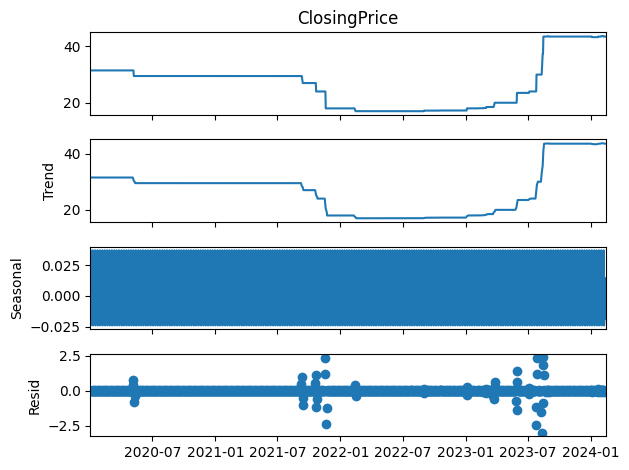

In [ ]:

results_atel = seasonal_decompose(aligned_atel['ClosingPrice'])
results_atel.plot();

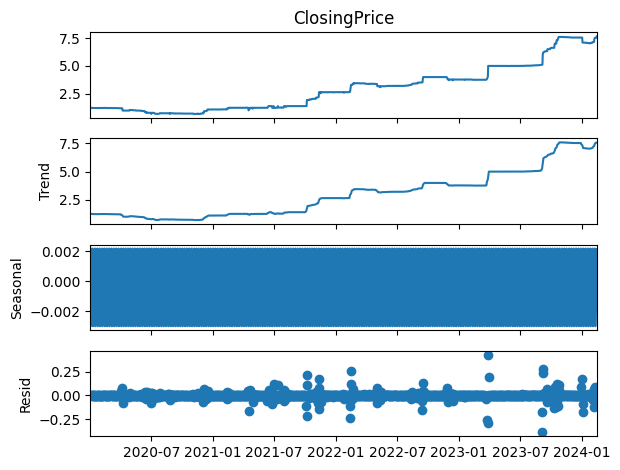

In [ ]:
results_cecz = seasonal_decompose(aligned_cecz['ClosingPrice'])
results_cecz.plot();

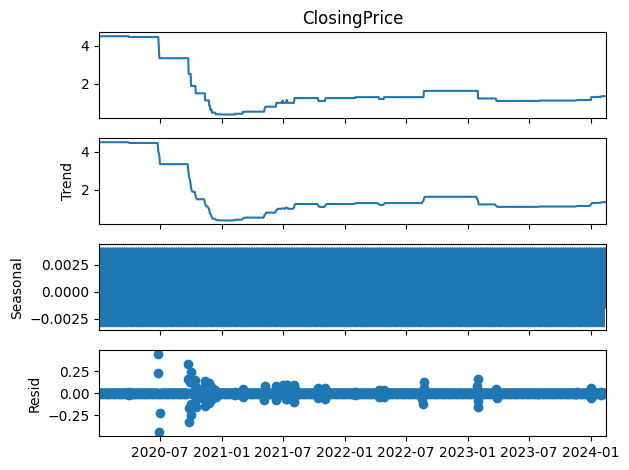

In [ ]:
results_reiz = seasonal_decompose(aligned_reiz['ClosingPrice'])
results_reiz.plot();

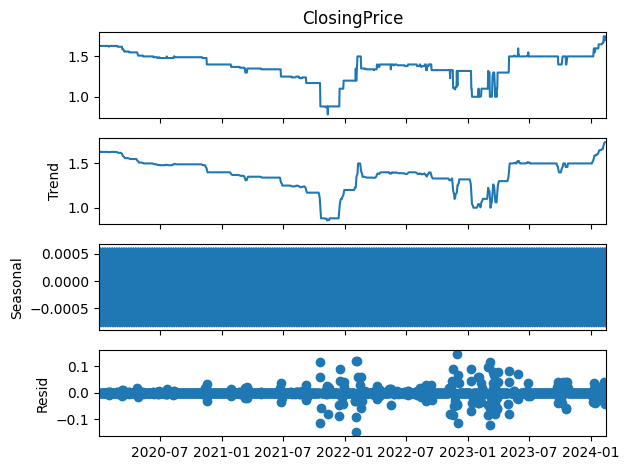

In [ ]:
results_scbl = seasonal_decompose(aligned_scbl['ClosingPrice'])
results_scbl.plot();

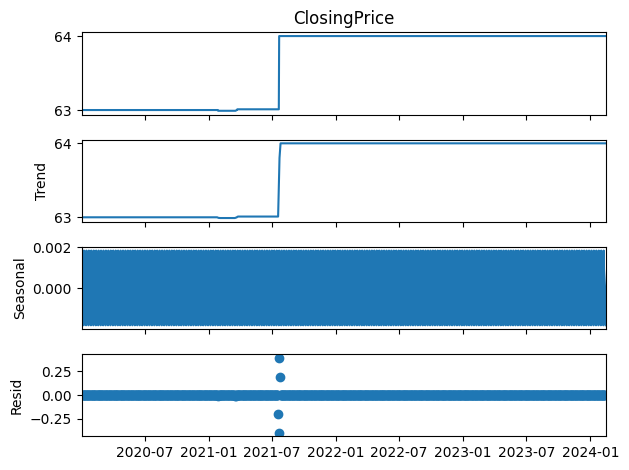

In [ ]:
results_shop = seasonal_decompose(aligned_shop['ClosingPrice'])
results_shop.plot();

# PREPARE MODEL FRAMEWORKS

INSTANTIATE SCALER TRANSFORMER

In [ ]:

scaler = MinMaxScaler()

NameError: name 'MinMaxScaler' is not defined

SPLIT DATA

In [ ]:
train_atel = aligned_atel.iloc[:-30]
test_atel = aligned_atel.iloc[-30:]

In [ ]:
train_cecz = aligned_cecz.iloc[:-30]
test_cecz = aligned_cecz.iloc[-30:]

In [ ]:
train_reiz = aligned_reiz.iloc[:-30]
test_reiz = aligned_atel.iloc[-30:]

In [ ]:
train_scbl = aligned_scbl.iloc[:-30]
test_scbl = aligned_scbl.iloc[-30:]

In [ ]:
train_shop = aligned_shop.iloc[:-30]
test_shop = aligned_shop.iloc[-30:]

TRANSFORM DATA

In [ ]:
scaler.fit(train_atel)
scaled_train_atel = scaler.transform(train_atel)
scaled_test_atel = scaler.transform(test_atel)

In [ ]:
scaler.fit(train_cecz)
scaled_train_cecz = scaler.transform(train_cecz)
scaled_test_cecz = scaler.transform(test_cecz)

In [ ]:
scaler.fit(train_reiz)
scaled_train_reiz = scaler.transform(train_reiz)
scaled_test_reiz = scaler.transform(test_reiz)

In [ ]:
scaler.fit(train_scbl)
scaled_train_scbl = scaler.transform(train_scbl)
scaled_test_scbl = scaler.transform(test_scbl)

In [ ]:
scaler.fit(train_shop)
scaled_train_shop = scaler.transform(train_shop)
scaled_test_shop = scaler.transform(test_shop)

In [ ]:
scaled_train_atel[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

DEFINE GENERATORS

In [ ]:
n_input = 20
n_features = 1

In [ ]:
atel_generator = TimeseriesGenerator(scaled_train_atel, scaled_train_atel, length=n_input, batch_size=1)

In [ ]:
cecz_generator = TimeseriesGenerator(scaled_train_cecz, scaled_train_cecz, length=n_input, batch_size=1)

In [ ]:
reiz_generator = TimeseriesGenerator(scaled_train_reiz, scaled_train_reiz, length=n_input, batch_size=1)

In [ ]:
scbl_generator = TimeseriesGenerator(scaled_train_scbl, scaled_train_scbl, length=n_input, batch_size=1)

In [ ]:
shop_generator = TimeseriesGenerator(scaled_train_shop, scaled_train_shop, length=n_input, batch_size=1)

In [ ]:
X,y = atel_generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Predict this y: 
 [[1.]]


# ATEL MODEL

ATEL MODEL

In [ ]:
#train_atel.head()
train_atel.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 385 entries, 2020-01-02 to 2021-06-23
Freq: B
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ClosingPrice  385 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB


In [ ]:
# train_atelx=train_atel.to_numpy()
# train_ately=train_atel.index.to_numpy().astype(str)
# test_atelx = test_atel.to_numpy()
# test_ately=test_atel.index.to_numpy().astype(str)

In [ ]:
# train_atelx

In [ ]:
# x_train = train_atelx
# y_train = train_ately
# x_test = test_atelx
# y_test = test_ately

In [ ]:
#pip install autokeras

In [ ]:
# import autokeras as ak

# # Define the LSTM model
# lstm_model = ak.RNNBlock(return_sequences=True)

# # Define the input node
# input_node = ak.Input()

# # Connect the input node to the LSTM model
# output_node = lstm_model(input_node)

# # Define the output node for regression tasks
# output_node = ak.RegressionHead()(output_node)

# # Initialize the AutoModel
# auto_model = ak.AutoModel(
#     inputs=input_node,
#     outputs=output_node,
#     max_trials=10,  # Number of different Keras Models to try
#     objective='val_loss'  # Objective to optimize
# )

# # Fit the AutoModel with your data
# auto_model.fit(
#     x_train, y_train,
#     epochs=100,
#     validation_split=0.2
# )

# # Evaluate the best model with testing data
# print(auto_model.evaluate(x_test, y_test))

# # Predict with the best model
# predicted_y = auto_model.predict(x_test)


In [ ]:
# define model
model_atel = Sequential()
model_atel.add(LSTM(1000, input_shape=(n_input, n_features)))
model_atel.add(Dense(1))
model_atel.compile(optimizer='adam', loss='mse')

In [ ]:
model_atel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# fit model
model_atel.fit(atel_generator,epochs=20)

Epoch 1/20
365/365 [==============================] - 8s 16ms/step - loss: 0.0234
Epoch 2/20
365/365 [==============================] - 5s 14ms/step - loss: 0.0118
Epoch 3/20
365/365 [==============================] - 5s 13ms/step - loss: 0.0084
Epoch 4/20
365/365 [==============================] - 6s 16ms/step - loss: 0.0077
Epoch 5/20
365/365 [==============================] - 5s 13ms/step - loss: 0.0061
Epoch 6/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0061
Epoch 7/20
365/365 [==============================] - 6s 16ms/step - loss: 0.0058
Epoch 8/20
365/365 [==============================] - 5s 13ms/step - loss: 0.0058
Epoch 9/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0054
Epoch 10/20
365/365 [==============================] - 5s 15ms/step - loss: 0.0049
Epoch 11/20
365/365 [==============================] - 5s 14ms/step - loss: 0.0046
Epoch 12/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0041
Epoch 13/20
3

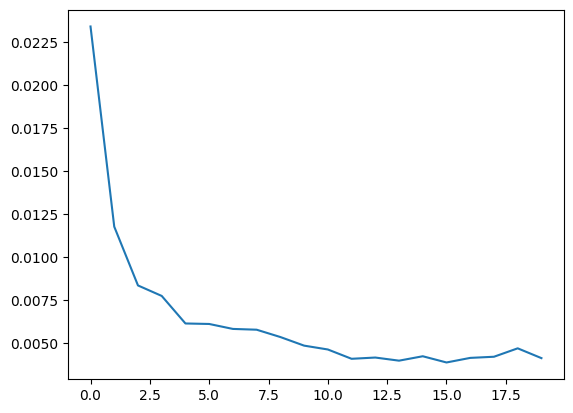

In [ ]:
loss_per_epoch = model_atel.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaled_train_atel[-20:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model_atel.predict(last_train_batch)

1/1 [==============================] - 0s 204ms/step


array([[-0.00053472]], dtype=float32)

In [ ]:
scaled_test_atel[0]

array([0.])

In [ ]:
test_predictions_atel = []

first_eval_batch = scaled_train_atel[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_atel)):

    # get the prediction value for the first batch
    current_pred = model_atel.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions_atel.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 25ms/step


In [ ]:
test_predictions_atel

[array([-0.00053472], dtype=float32),
 array([-0.00061369], dtype=float32),
 array([-0.00067642], dtype=float32),
 array([-0.00072718], dtype=float32),
 array([-0.00076792], dtype=float32),
 array([-0.00080034], dtype=float32),
 array([-0.00082597], dtype=float32),
 array([-0.00084611], dtype=float32),
 array([-0.00086182], dtype=float32),
 array([-0.00087404], dtype=float32),
 array([-0.00088346], dtype=float32),
 array([-0.00089071], dtype=float32),
 array([-0.00089625], dtype=float32),
 array([-0.00090045], dtype=float32),
 array([-0.00090359], dtype=float32),
 array([-0.00090595], dtype=float32),
 array([-0.0009077], dtype=float32),
 array([-0.00090897], dtype=float32),
 array([-0.00090999], dtype=float32),
 array([-0.0009107], dtype=float32),
 array([-0.00091126], dtype=float32),
 array([-0.00091169], dtype=float32),
 array([-0.00091199], dtype=float32),
 array([-0.00091226], dtype=float32),
 array([-0.00091243], dtype=float32),
 array([-0.00091255], dtype=float32),
 array([-0.000

In [ ]:
test_atel.head()

,ClosingPrice
timestamp,
2021-06-24,29.48
2021-06-25,29.48
2021-06-28,29.48
2021-06-29,29.48
2021-06-30,29.48


In [ ]:
true_predictions_atel = scaler.inverse_transform(test_predictions_atel)

In [ ]:
test_atel['Predictions'] = true_predictions_atel

In [ ]:
test_atel.head()

,ClosingPrice,Predictions
timestamp,,
2021-06-24,29.48,62.989989
2021-06-25,29.48,62.989988
2021-06-28,29.48,62.989986
2021-06-29,29.48,62.989985
2021-06-30,29.48,62.989985


<Axes: xlabel='timestamp'>

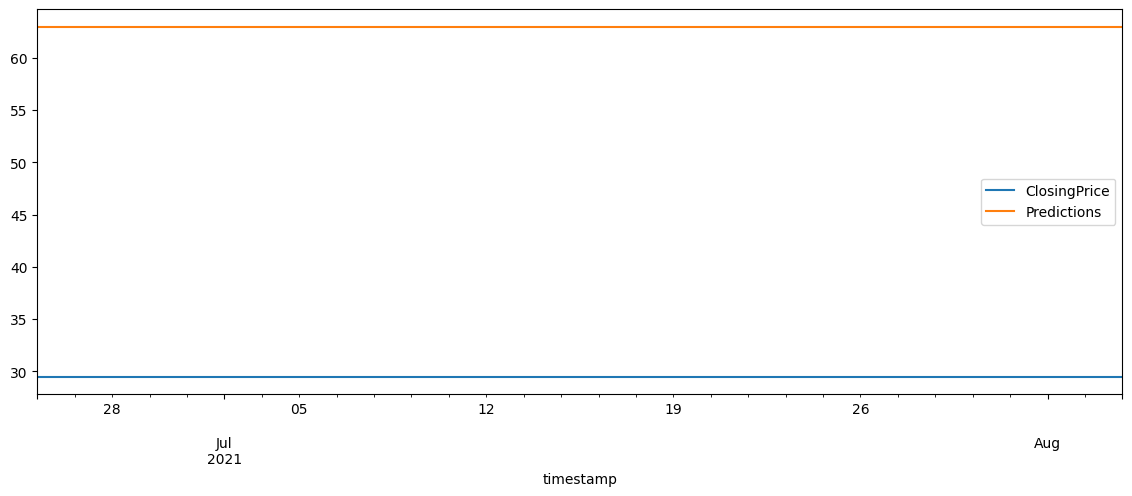

In [ ]:
test_atel.plot(figsize=(14,5))

In [ ]:
rmse_atel=sqrt(mean_squared_error(test_atel['ClosingPrice'],test_atel['Predictions']))
print(rmse_atel)

33.50998288722839


# CECZ MODEL

CECZ MODEL

In [ ]:
# define model
model_cecz = Sequential()
model_cecz.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_cecz.add(Dense(1))
model_cecz.compile(optimizer='adam', loss='mse')

In [ ]:
model_cecz.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# fit model
model_cecz.fit(cecz_generator,epochs=20)

Epoch 1/20
365/365 [==============================] - 11s 26ms/step - loss: 0.0421
Epoch 2/20
365/365 [==============================] - 9s 24ms/step - loss: 0.0071
Epoch 3/20
365/365 [==============================] - 5s 13ms/step - loss: 0.0059
Epoch 4/20
365/365 [==============================] - 6s 16ms/step - loss: 0.0041
Epoch 5/20
365/365 [==============================] - 6s 16ms/step - loss: 0.0036
Epoch 6/20
365/365 [==============================] - 5s 13ms/step - loss: 0.0033
Epoch 7/20
365/365 [==============================] - 10s 27ms/step - loss: 0.0034
Epoch 8/20
365/365 [==============================] - 5s 13ms/step - loss: 0.0030
Epoch 9/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0027
Epoch 10/20
365/365 [==============================] - 6s 15ms/step - loss: 0.0026
Epoch 11/20
365/365 [==============================] - 5s 13ms/step - loss: 0.0025
Epoch 12/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0028
Epoch 13/20

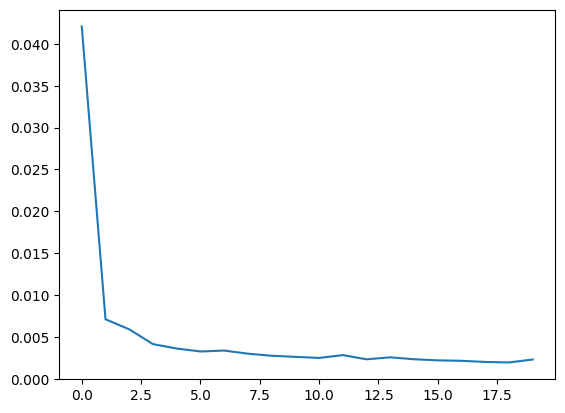

In [ ]:
loss_per_epoch = model_cecz.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaled_train_cecz[-20:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model_cecz.predict(last_train_batch)

1/1 [==============================] - 0s 182ms/step


array([[0.97943]], dtype=float32)

In [ ]:
scaled_test_cecz[0]

array([1.])

In [ ]:
test_predictions_cecz = []

first_eval_batch = scaled_train_cecz[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_cecz)):

    # get the prediction value for the first batch
    current_pred = model_cecz.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions_cecz.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 27ms/step


In [ ]:
test_predictions_cecz

[array([0.97943], dtype=float32),
 array([0.9625855], dtype=float32),
 array([0.94292486], dtype=float32),
 array([0.9230229], dtype=float32),
 array([0.9032337], dtype=float32),
 array([0.88374996], dtype=float32),
 array([0.8647053], dtype=float32),
 array([0.84618723], dtype=float32),
 array([0.8282474], dtype=float32),
 array([0.8109128], dtype=float32),
 array([0.794191], dtype=float32),
 array([0.7780778], dtype=float32),
 array([0.7625583], dtype=float32),
 array([0.7475038], dtype=float32),
 array([0.73296535], dtype=float32),
 array([0.7189347], dtype=float32),
 array([0.7053878], dtype=float32),
 array([0.6922988], dtype=float32),
 array([0.679642], dtype=float32),
 array([0.66739017], dtype=float32),
 array([0.6555196], dtype=float32),
 array([0.64400786], dtype=float32),
 array([0.63283455], dtype=float32),
 array([0.62198067], dtype=float32),
 array([0.61142796], dtype=float32),
 array([0.6011603], dtype=float32),
 array([0.59116226], dtype=float32),
 array([0.58141917], d

In [ ]:
test_cecz.head()

,ClosingPrice
timestamp,
2021-06-24,1.25
2021-06-25,1.25
2021-06-28,1.25
2021-06-29,1.25
2021-06-30,1.25


In [ ]:
true_predictions_cecz = scaler.inverse_transform(test_predictions_cecz)

In [ ]:
test_cecz['Predictions'] = true_predictions_cecz

In [ ]:
test_cecz.head()

,ClosingPrice,Predictions
timestamp,,
2021-06-24,1.25,63.009589
2021-06-25,1.25,63.009252
2021-06-28,1.25,63.008858
2021-06-29,1.25,63.008460
2021-06-30,1.25,63.008065


<Axes: xlabel='timestamp'>

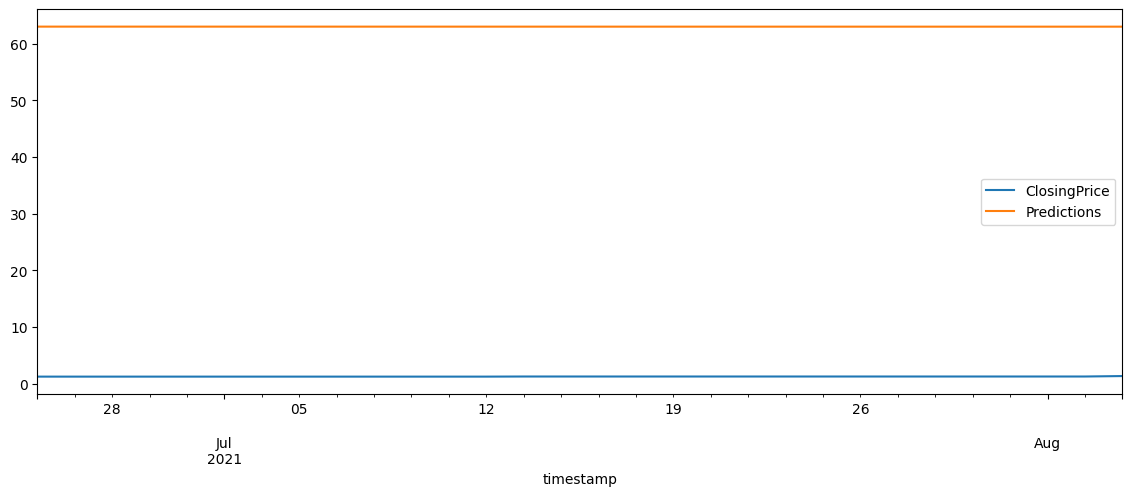

In [ ]:
test_cecz.plot(figsize=(14,5))

In [ ]:
rmse_cecz=sqrt(mean_squared_error(test_cecz['ClosingPrice'],test_cecz['Predictions']))
print(rmse_cecz)

61.74086874646675


# REIZ MODEL

REIZ MODEL

In [ ]:
# define model
model_reiz = Sequential()
model_reiz.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_reiz.add(Dense(1))
model_reiz.compile(optimizer='adam', loss='mse')

In [ ]:
model_reiz.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# fit model
model_reiz.fit(reiz_generator,epochs=20)

Epoch 1/20
365/365 [==============================] - 8s 17ms/step - loss: 0.0192
Epoch 2/20
365/365 [==============================] - 5s 13ms/step - loss: 0.0029
Epoch 3/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0023
Epoch 4/20
365/365 [==============================] - 5s 13ms/step - loss: 0.0025
Epoch 5/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0020
Epoch 6/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0013
Epoch 7/20
365/365 [==============================] - 5s 13ms/step - loss: 0.0014
Epoch 8/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0014
Epoch 9/20
365/365 [==============================] - 5s 13ms/step - loss: 0.0012
Epoch 10/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0012
Epoch 11/20
365/365 [==============================] - 5s 13ms/step - loss: 0.0013
Epoch 12/20
365/365 [==============================] - 6s 17ms/step - loss: 9.2792e-04
Epoch 13/

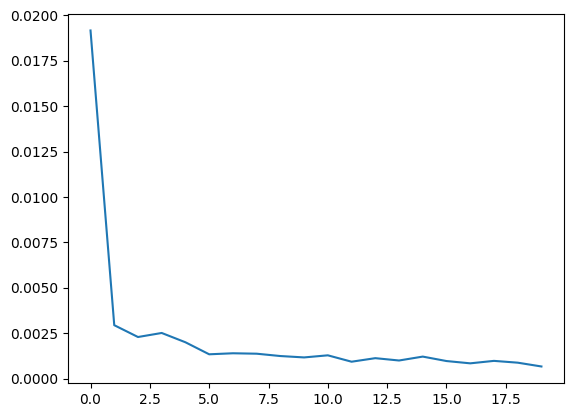

In [ ]:
loss_per_epoch = model_reiz.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaled_train_reiz[-20:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model_reiz.predict(last_train_batch)

1/1 [==============================] - 0s 180ms/step


array([[0.0976935]], dtype=float32)

In [ ]:
scaled_test_reiz[0]

array([7.09512195])

In [ ]:
test_predictions_reiz = []

first_eval_batch = scaled_train_reiz[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_reiz)):

    # get the prediction value for the first batch
    current_pred = model_reiz.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions_reiz.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 34ms/step


In [ ]:
test_predictions_reiz

[array([0.0976935], dtype=float32),
 array([0.09661874], dtype=float32),
 array([0.09538043], dtype=float32),
 array([0.09402198], dtype=float32),
 array([0.09258268], dtype=float32),
 array([0.09109404], dtype=float32),
 array([0.08958071], dtype=float32),
 array([0.08806153], dtype=float32),
 array([0.08655049], dtype=float32),
 array([0.08505765], dtype=float32),
 array([0.08358997], dtype=float32),
 array([0.08215193], dtype=float32),
 array([0.08074618], dtype=float32),
 array([0.07937401], dtype=float32),
 array([0.07803575], dtype=float32),
 array([0.07673848], dtype=float32),
 array([0.0754822], dtype=float32),
 array([0.07426642], dtype=float32),
 array([0.07309068], dtype=float32),
 array([0.07195417], dtype=float32),
 array([0.07085631], dtype=float32),
 array([0.06979736], dtype=float32),
 array([0.0687758], dtype=float32),
 array([0.06779085], dtype=float32),
 array([0.06684185], dtype=float32),
 array([0.06592801], dtype=float32),
 array([0.06505111], dtype=float32),
 arr

In [ ]:
test_reiz.head()

,ClosingPrice
timestamp,
2021-06-24,29.48
2021-06-25,29.48
2021-06-28,29.48
2021-06-29,29.48
2021-06-30,29.48


In [ ]:
true_predictions_reiz = scaler.inverse_transform(test_predictions_reiz)

In [ ]:
test_reiz['Predictions'] = true_predictions_reiz

In [ ]:
test_reiz.head()

,ClosingPrice,Predictions
timestamp,,
2021-06-24,29.48,62.991954
2021-06-25,29.48,62.991932
2021-06-28,29.48,62.991908
2021-06-29,29.48,62.991880
2021-06-30,29.48,62.991852


<Axes: xlabel='timestamp'>

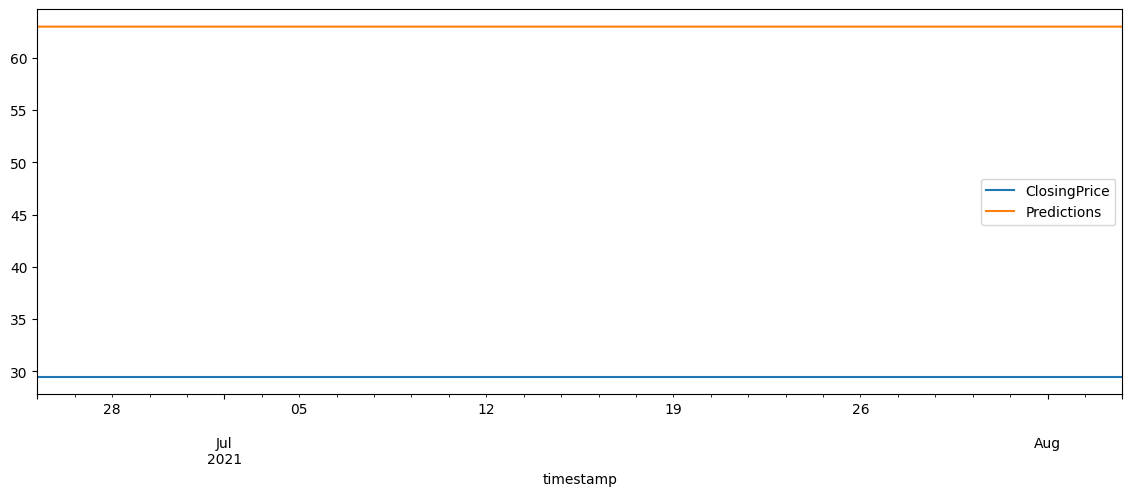

In [ ]:
test_reiz.plot(figsize=(14,5))

In [ ]:
rmse_reiz=sqrt(mean_squared_error(test_reiz['ClosingPrice'],test_reiz['Predictions']))
print(rmse_reiz)

33.5115716178722


# SCBL MODEL

SCBL MODEL

In [ ]:
# define model
model_scbl = Sequential()
model_scbl.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_scbl.add(Dense(1))
model_scbl.compile(optimizer='adam', loss='mse')

In [ ]:
model_scbl.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# fit model
model_scbl.fit(scbl_generator,epochs=20)

Epoch 1/20
365/365 [==============================] - 7s 13ms/step - loss: 0.0098
Epoch 2/20
365/365 [==============================] - 5s 14ms/step - loss: 0.0021
Epoch 3/20
365/365 [==============================] - 6s 16ms/step - loss: 0.0019
Epoch 4/20
365/365 [==============================] - 6s 18ms/step - loss: 0.0016
Epoch 5/20
365/365 [==============================] - 5s 14ms/step - loss: 0.0015
Epoch 6/20
365/365 [==============================] - 7s 18ms/step - loss: 0.0014
Epoch 7/20
365/365 [==============================] - 5s 13ms/step - loss: 0.0011
Epoch 8/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0013
Epoch 9/20
365/365 [==============================] - 5s 13ms/step - loss: 0.0011
Epoch 10/20
365/365 [==============================] - 6s 16ms/step - loss: 0.0011
Epoch 11/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0011
Epoch 12/20
365/365 [==============================] - 5s 14ms/step - loss: 0.0011
Epoch 13/20
3

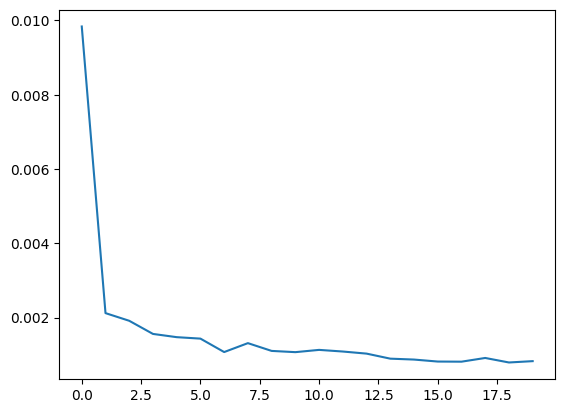

In [ ]:
loss_per_epoch = model_scbl.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaled_train_scbl[-20:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model_scbl.predict(last_train_batch)

1/1 [==============================] - 0s 195ms/step


array([[0.1287534]], dtype=float32)

In [ ]:
scaled_test_scbl[0]

array([0.12121212])

In [ ]:
test_predictions_scbl = []

first_eval_batch = scaled_train_scbl[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_scbl)):

    # get the prediction value for the first batch
    current_pred = model_scbl.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions_scbl.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [ ]:
test_predictions_scbl

[array([0.1287534], dtype=float32),
 array([0.13188843], dtype=float32),
 array([0.13488083], dtype=float32),
 array([0.13757846], dtype=float32),
 array([0.13987763], dtype=float32),
 array([0.1417319], dtype=float32),
 array([0.14315382], dtype=float32),
 array([0.14417449], dtype=float32),
 array([0.14484656], dtype=float32),
 array([0.14523377], dtype=float32),
 array([0.14540267], dtype=float32),
 array([0.14541644], dtype=float32),
 array([0.14533086], dtype=float32),
 array([0.14519198], dtype=float32),
 array([0.1450351], dtype=float32),
 array([0.14488548], dtype=float32),
 array([0.14476012], dtype=float32),
 array([0.14466769], dtype=float32),
 array([0.14460982], dtype=float32),
 array([0.14458355], dtype=float32),
 array([0.14458314], dtype=float32),
 array([0.14460218], dtype=float32),
 array([0.14463402], dtype=float32),
 array([0.14467338], dtype=float32),
 array([0.1447152], dtype=float32),
 array([0.14475566], dtype=float32),
 array([0.14479202], dtype=float32),
 arra

In [ ]:
test_scbl.head()

,ClosingPrice
timestamp,
2021-06-24,1.34
2021-06-25,1.34
2021-06-28,1.34
2021-06-29,1.34
2021-06-30,1.34


In [ ]:
true_predictions_scbl = scaler.inverse_transform(test_predictions_scbl)

In [ ]:
test_scbl['Predictions'] = true_predictions_scbl

In [ ]:
test_scbl.head()

,ClosingPrice,Predictions
timestamp,,
2021-06-24,1.34,62.992575
2021-06-25,1.34,62.992638
2021-06-28,1.34,62.992698
2021-06-29,1.34,62.992752
2021-06-30,1.34,62.992798


<Axes: xlabel='timestamp'>

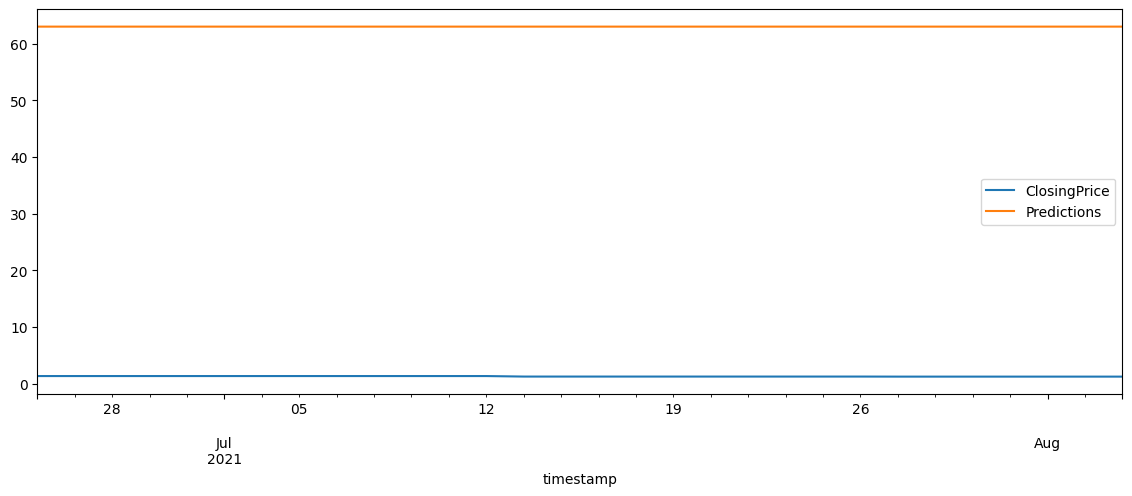

In [ ]:
test_scbl.plot(figsize=(14,5))

In [ ]:
rmse_scbl=sqrt(mean_squared_error(test_scbl['ClosingPrice'],test_scbl['Predictions']))
print(rmse_scbl)

61.70621062944423


# SHOP MODEL

SHOP MODEL

In [ ]:
# define model
model_shop = Sequential()
model_shop.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_shop.add(Dense(1))
model_shop.compile(optimizer='adam', loss='mse')

In [ ]:
model_shop.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# fit model
model_shop.fit(shop_generator,epochs=20)

Epoch 1/20
365/365 [==============================] - 9s 17ms/step - loss: 0.0300
Epoch 2/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0088
Epoch 3/20
365/365 [==============================] - 5s 14ms/step - loss: 0.0061
Epoch 4/20
365/365 [==============================] - 5s 14ms/step - loss: 0.0072
Epoch 5/20
365/365 [==============================] - 5s 14ms/step - loss: 0.0049
Epoch 6/20
365/365 [==============================] - 5s 15ms/step - loss: 0.0044
Epoch 7/20
365/365 [==============================] - 5s 15ms/step - loss: 0.0036
Epoch 8/20
365/365 [==============================] - 5s 14ms/step - loss: 0.0038
Epoch 9/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0031
Epoch 10/20
365/365 [==============================] - 5s 13ms/step - loss: 0.0029
Epoch 11/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0030
Epoch 12/20
365/365 [==============================] - 6s 17ms/step - loss: 0.0026
Epoch 13/20
3

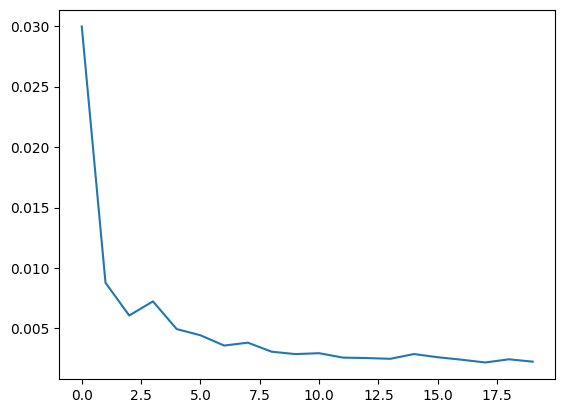

In [ ]:
loss_per_epoch = model_shop.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaled_train_shop[-20:]

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model_shop.predict(last_train_batch)

1/1 [==============================] - 0s 189ms/step


array([[1.0284007]], dtype=float32)

In [ ]:
scaled_test_shop[0]

array([1.])

In [ ]:
test_predictions_shop = []

first_eval_batch = scaled_train_shop[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_shop)):

    # get the prediction value for the first batch
    current_pred = model_shop.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions_shop.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [ ]:
test_predictions_shop

[array([1.0284007], dtype=float32),
 array([1.0537592], dtype=float32),
 array([1.0853337], dtype=float32),
 array([1.118772], dtype=float32),
 array([1.153125], dtype=float32),
 array([1.1884359], dtype=float32),
 array([1.224981], dtype=float32),
 array([1.2630106], dtype=float32),
 array([1.3027005], dtype=float32),
 array([1.3441663], dtype=float32),
 array([1.3874954], dtype=float32),
 array([1.4327719], dtype=float32),
 array([1.4800875], dtype=float32),
 array([1.5294417], dtype=float32),
 array([1.5806172], dtype=float32),
 array([1.6333697], dtype=float32),
 array([1.687524], dtype=float32),
 array([1.7430713], dtype=float32),
 array([1.799938], dtype=float32),
 array([1.8581793], dtype=float32),
 array([1.9179845], dtype=float32),
 array([1.9795067], dtype=float32),
 array([2.042835], dtype=float32),
 array([2.1080966], dtype=float32),
 array([2.1753974], dtype=float32),
 array([2.2447176], dtype=float32),
 array([2.3164482], dtype=float32),
 array([2.39115], dtype=float32),


In [ ]:
test_shop.head()

,ClosingPrice
timestamp,
2021-06-24,63.01
2021-06-25,63.01
2021-06-28,63.01
2021-06-29,63.01
2021-06-30,63.01


In [ ]:
true_predictions_shop = scaler.inverse_transform(test_predictions_shop)

In [ ]:
test_shop['Predictions'] = true_predictions_shop

In [ ]:
test_shop.head()

,ClosingPrice,Predictions
timestamp,,
2021-06-24,63.01,63.010568
2021-06-25,63.01,63.011075
2021-06-28,63.01,63.011707
2021-06-29,63.01,63.012375
2021-06-30,63.01,63.013063


<Axes: xlabel='timestamp'>

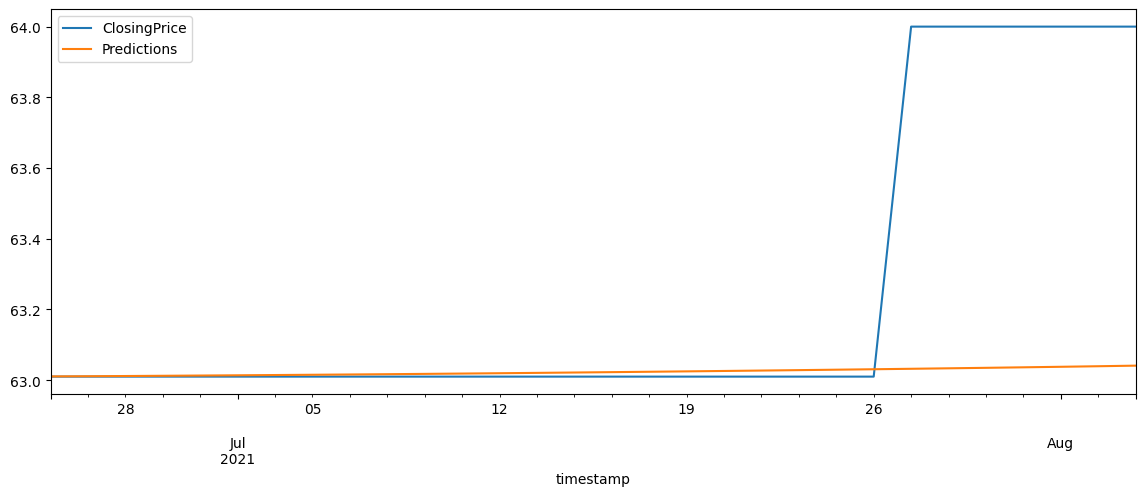

In [ ]:
test_shop.plot(figsize=(14,5))

In [ ]:
rmse_shop=sqrt(mean_squared_error(test_shop['ClosingPrice'],test_shop['Predictions']))
print(rmse_shop)

0.4655465759209535


# MAE

In [ ]:
mae_atel=mean_absolute_error(test_shop['ClosingPrice'],test_shop['Predictions'])
mae_cecz=mean_absolute_error(test_shop['ClosingPrice'],test_shop['Predictions'])
mae_reiz=mean_absolute_error(test_shop['ClosingPrice'],test_shop['Predictions'])
mae_scbl=mean_absolute_error(test_shop['ClosingPrice'],test_shop['Predictions'])
mae_shop=mean_absolute_error(test_shop['ClosingPrice'],test_shop['Predictions'])
print(rmse_atel,mae_atel)
print(rmse_cecz,mae_cecz)
print(rmse_reiz,mae_reiz)
print(rmse_scbl,mae_scbl)
print(rmse_shop,mae_shop)

33.50998288722839 0.2320525363286336
61.74086874646675 0.2320525363286336
33.5115716178722 0.2320525363286336
61.70621062944423 0.2320525363286336
0.4655465759209535 0.2320525363286336
